In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

## Langsmith Tracking And Tracing
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"]=os.getenv("LANGCHAIN_PROJECT")
os.environ["PINECONE_API_KEY"]=os.getenv("PINECONE_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"]="true"

In [3]:
os.environ['HF_TOKEN']=os.getenv("HF_TOKEN")

In [4]:
FILE_PATH = r"C:\Users\srich\Downloads\TA_wrkbk.pdf"

In [5]:
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

In [6]:
loader = PyPDFLoader(FILE_PATH)
docs = loader.load()

In [7]:
len(docs)

172

In [8]:
splitter = RecursiveCharacterTextSplitter(chunk_size=1000,chunk_overlap=200)
split_docs = splitter.split_documents(docs)

In [9]:
from uuid import uuid4
uuids = [str(uuid4()) for _ in range(len(split_docs))]

In [10]:
from langchain_huggingface import HuggingFaceEmbeddings
embedding = HuggingFaceEmbeddings(model_name="all-mpnet-base-v2")

d:\Agentic_AI\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
from pinecone import Pinecone
pinecone_api_key = os.environ.get("PINECONE_API_KEY")
pc = Pinecone(api_key=pinecone_api_key)

In [12]:
index_name = 'nism-rag'
index=pc.Index(index_name)

In [13]:
from langchain_pinecone import PineconeVectorStore
vectorstore = PineconeVectorStore(index=index,embedding=embedding)

In [14]:
MAX_BYTES = 4194304  # 4 MiB

def is_valid_doc(doc):
    size = len(doc.page_content.encode('utf-8'))
    return size <= MAX_BYTES

# Filter out oversized documents
valid_docs = [doc for doc in split_docs if is_valid_doc(doc)]
oversized_docs = [doc for doc in split_docs if not is_valid_doc(doc)]

print(f"Valid docs: {len(valid_docs)}, Oversized docs: {len(oversized_docs)}")

# If you have UUIDs, sync them with the filtered docs
valid_ids = [uuid for doc, uuid in zip(split_docs, uuids) if is_valid_doc(doc)]

BATCH_SIZE = 50  # try 20–50 if the problem persists

for i in range(0, len(valid_docs), BATCH_SIZE):
    batch_docs = valid_docs[i:i + BATCH_SIZE]
    batch_ids = valid_ids[i:i + BATCH_SIZE]
    try:
        vectorstore.add_documents(documents=batch_docs, ids=batch_ids)
        print(f"Uploaded batch {i // BATCH_SIZE + 1}")
    except Exception as e:
        print(f"Failed to upload batch {i // BATCH_SIZE + 1}: {e}")



Valid docs: 383, Oversized docs: 0
Uploaded batch 1
Uploaded batch 2
Uploaded batch 3
Uploaded batch 4
Uploaded batch 5
Uploaded batch 6
Uploaded batch 7
Uploaded batch 8


In [15]:
retriever = vectorstore.as_retriever(
    search_type="similarity", 
    search_kwargs={"k": 5}      
)


In [26]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [27]:
result = retriever.invoke("what is hammer pattern?")

In [82]:
from langchain_google_genai import ChatGoogleGenerativeAI
model=ChatGoogleGenerativeAI(model='gemini-1.5-flash')

In [83]:
import operator
from typing import List
from pydantic import BaseModel,Field
from langchain.prompts import PromptTemplate
from typing import TypedDict,Annotated,Sequence
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

In [84]:
class TopicSelection(BaseModel):
    topic: str = Field(description="selected topic")
    reason: str = Field(description="Reason behind topic selection")

In [85]:
from langchain.output_parsers import PydanticOutputParser
parser = PydanticOutputParser(pydantic_object=TopicSelection)
parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"topic": {"description": "selected topic", "title": "Topic", "type": "string"}, "reason": {"description": "Reason behind topic selection", "title": "Reason", "type": "string"}}, "required": ["topic", "reason"]}\n```'

In [86]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [87]:
# Supervisor
def function1(state: AgentState):
    question = state["messages"][-1]
    print("Question: ",question)

    template = """
        Your task is to classify the given user query into two of the following categories: [Stock,Not related]
        Only respond with the the category name and nothing else.
        user query : {question}
        {format_instructions}
    """
    prompt = PromptTemplate(
        template=template,
        input_variable=["question"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )

    chain = prompt | model | parser

    response = chain.invoke({"question": question})
    print("parsed response: ", response)

    return {"messages": [response.topic]} 

    

In [ ]:
# RAG Function
def function2(state: AgentState):
    print("--- RAG ---")
    query = state["messages"][0]

    prompt=PromptTemplate(
        template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. 
            If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:""",
        
        input_variables=['context', 'question']
    )

    rag_chain = (
        {"context": retriever | format_docs,
         "question": RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
    )

    result = rag_chain.invoke(query)
    return {"messages": [result]}


In [89]:
# LLM Function
def function3(state: AgentState):
    print("--- LLM ---")
    query = state["messages"][0]
    complete_query = "Anwer the follow question with you knowledge of the real world. Following is the user question: " + query
    response = model.invoke(complete_query)
    return {"messages": [response.content]}

In [90]:
# Router
def router(state: AgentState):
    print("--- Router ---")

    last_message = state["messages"][-1]
    print("last message: ",last_message)

    if "stock" in last_message.lower():
        return "RAG call"
    else:
        return "LLM call"

## Graph Building

In [91]:
from langgraph.graph import StateGraph,END

In [92]:
workflow = StateGraph(AgentState)

In [93]:
workflow.add_node("Supervisor",function1)
workflow.add_node("RAG",function2)
workflow.add_node("LLM",function3)

In [94]:
workflow.set_entry_point("Supervisor")

In [95]:
workflow.add_conditional_edges(
    "Supervisor",
    router,
    {
        "RAG call": "RAG",
        "LLM call": "LLM"
    }
)

In [96]:
app = workflow.compile()

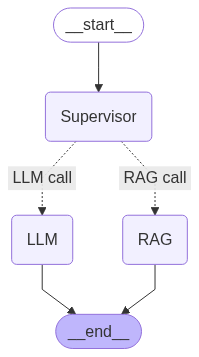

In [97]:
app

In [98]:
state={"messages": ["hi"]}
app.invoke(state)

Question:  hi
parsed response:  topic='Not related' reason="The query 'hi' is a generic greeting and does not relate to stock information."
--- Router ---
last message:  Not related
--- LLM ---


{'messages': ['hi', 'Not related', 'Hi there!']}

In [99]:
state={"messages": ["What is head and shoulders top reversal?"]}
app.invoke(state)

Question:  What is head and shoulders top reversal?
parsed response:  topic='Stock' reason='Head and shoulders is a chart pattern used in stock market analysis to predict price reversals.'
--- Router ---
last message:  Stock
--- RAG ---


{'messages': ['What is head and shoulders top reversal?',
  'Stock',
  "A head and shoulders top reversal is a chart pattern indicating a potential trend reversal from uptrend to downtrend.  It consists of three peaks (left shoulder, head, right shoulder) with the middle peak being the highest, followed by a neckline break.  The pattern's completion signals a potential major trend reversal."]}